## Notebook for running Gene Set Enrichment Analysis (GSEA) Enrichr using gseapy looking specifically at the SCRN-DA 3'APA (PDUI) QTS features
[gseapy docs](https://gseapy.readthedocs.io/en/latest/introduction.html)

In [1]:
!date

Wed Feb  8 15:34:31 UTC 2023


#### import libraries

In [2]:
import gseapy
from gseapy.enrichr import Enrichr
from pandas import DataFrame, concat, pivot, read_csv
from math import ceil
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from seaborn import heatmap, barplot, color_palette
import statsmodels.stats.multitest as smm
from numpy import log10

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# naming
cohort = 'foundin'
dx = 'PD'
modality = 'PDUI-DA'
day = 'da65'
set_name = f'{cohort}_{day}_{modality}'

# directories
wrk_dir = '/home/jupyter/foundin_qtl'
qts_dir = f'{wrk_dir}/qts'
figures_dir = f'{wrk_dir}/figures'
quants_dir = f'{wrk_dir}/quants'

# input files
qts_file = f'{qts_dir}/{set_name}.qts.csv'
pdui_features_file = f'{quants_dir}/{cohort}_{modality}.features.csv'

# output files
results_file = f'{figures_dir}/{set_name}.qts.{dx}.gsea_enrichr.csv'

# variables
DEBUG = True
dpi_value = 100
marker_sets = ['GO_Biological_Process_2021', 
               'GO_Cellular_Component_2021']


### check the enrichments

In [4]:
if DEBUG:
    gene_set_names = gseapy.get_library_name(organism='Human')
    print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

In [5]:
def find_enrichment(name: str, genes: list, sets,
                    verbose: bool=False) -> DataFrame:
    enr_res = gseapy.enrichr(gene_list=genes,
                             organism='Human',
                             gene_sets=sets,
                             cutoff=0.5)
    enr_res.results['modality'] = name    
    if verbose:
        print(f'full {sets} results shape{enr_res.results.shape}')        
        sig = enr_res.results.loc[enr_res.results['Adjusted P-value'] <= 0.05]
        print(f'significant {sets} results shape{sig.shape}')
        display(sig)
    return enr_res.results

# compute B&H FDR for given p-values
def compute_fdr(pvalues):
    bh_adj = smm.fdrcorrection(pvalues)
    return bh_adj[1]

In [6]:
for gene_set in marker_sets:
    print(gene_set)

GO_Biological_Process_2021
GO_Cellular_Component_2021


### load QTS results

In [7]:
qts_df = read_csv(qts_file)
print(f'full QTS results shape {qts_df.shape}')
# subset to just the statistically significant results
qts_df = qts_df.loc[qts_df.bh_fdr <= 0.05]
print(f'significant QTS results shape {qts_df.shape}')
if DEBUG:
    display(qts_df.head())

full QTS results shape (8240, 7)
significant QTS results shape (152, 7)


,Loci,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr
12,chr15:66499323-66499652,0.283699,0.077244,0.107379,14.0,0.000497,0.043761
16,chr11:66605702-66605912,0.518748,0.144859,0.222634,14.0,0.000666,0.045811
104,chr2:61164354-61164808,0.401645,0.101268,0.168361,14.0,0.000189,0.040504
207,chr2:61164354-61164825,0.329917,0.088784,0.157362,14.0,0.000432,0.043761
229,chr5:73505192-73505635,0.350021,0.092764,0.112112,14.0,0.000359,0.041279


### load the PDUI annotations
need to attach a gene symbol to the 3'APA features

In [8]:
%%time
annots_df = read_csv(pdui_features_file)
print(f'annotations shape: {annots_df.shape}')

if DEBUG:
    display(annots_df.head())

annotations shape: (16720, 7)


,Loci,Gene,fit_value,Predicted_Proximal_APA,chrom,start,stop
0,chr1:629062-629433,lnc-SAMD11-15,13073740.5,629213,chr1,629062,629433
1,chr1:629640-630683,MTND2P28,13152418.3,629791,chr1,629640,630683
2,chr1:631074-632325,MTCO1P12,1072690.0,631359,chr1,631074,632325
3,chr1:632757-633438,MTCO2P12,17748161.1,632908,chr1,632757,633438
4,chr1:632770-633463,lnc-SAMD11-13,16733626.1,633282,chr1,632770,633463


CPU times: user 23.8 ms, sys: 3.87 ms, total: 27.7 ms
Wall time: 25.4 ms


In [9]:
### create gene list for 3'APA features
features_df = annots_df.loc[annots_df.Loci.isin(qts_df.Loci)]
print(f'feature of interest annotation shape is {features_df.shape}')
gene_list = list(features_df.Gene.unique())
print(f'{len(gene_list)} unique genes map to features of interest')
print(gene_list)
if DEBUG:
    display(features_df.head()) 

feature of interest annotation shape is (152, 7)
95 unique genes map to features of interest
['MTATP6P1', 'ACOT7', 'PARK7', 'ATP5IF1', 'lnc-MANEAL-3', 'SHISAL2A', 'RABGGTB', 'SARS', 'CELSR2', 'PHGDH', 'lnc-ARHGEF2-3', 'GAS5', 'ARPC5', 'NENF', 'ARF1', 'AC016747.4', 'C2orf74', 'MDH1', 'ASNSD1', 'IGFBP2', 'PNKD', 'SCG2', 'VGLL4', 'SLC25A36', 'SUB1', 'BTF3', 'HINT1', 'NPM1', 'DBN1', 'DDX41', 'ECI2', 'FLOT1', 'SNRPC', 'CCDC167', 'EEF1A1', 'lnc-CGAS-3', 'DYNLT1', 'ASNS', 'TUSC3', 'RPS20', 'CARD19', 'OLFM1', 'NPDC1', 'VIM', 'DNAJC12', 'lnc-PSMA1-2', 'PSMA1', 'PPP1R14B', 'TM7SF2', 'CCS', 'TMEM134', 'KLHL35', 'lnc-SIDT2-2', 'TRAPPC4', 'HSPA8', 'NDUFA12', 'SLC25A3', 'DYNLL1', 'POP5', 'KATNAL1', 'CCNB1IP1', 'GMPR2', 'SYNJ2BP-COX16', 'COX16', 'DYNC1H1', 'CKB', 'SCG5', 'SERF2', 'lnc-SNAPC5-3', 'RPL4', 'APRT', 'ANKRD11', 'PFN1', 'GOSR1', 'PSMD11', 'RPS26P8', 'DDX5', 'SEPT9', 'ACTG1', 'ANAPC11', 'TRAPPC5', 'C19orf53', 'PDCD5', 'ECH1', 'MEIS3', 'lnc-RPL13A-1', 'lnc-TRIM28-14', 'RBCK1', 'DYNLRB1', 'CPN

,Loci,Gene,fit_value,Predicted_Proximal_APA,chrom,start,stop
5,chr1:633696-634376,MTATP6P1,300067297.0,634212,chr1,633696,634376
65,chr1:6264269-6264695,ACOT7,109733.8,6264390,chr1,6264269,6264695
66,chr1:6264273-6264695,ACOT7,110606.4,6264391,chr1,6264273,6264695
76,chr1:7984894-7985279,PARK7,750241.0,7985146,chr1,7984894,7985279
78,chr1:7984894-7985281,PARK7,746811.9,7985146,chr1,7984894,7985281


In [10]:
# look at the PARK7 results
park7_features = features_df.loc[features_df.Gene == 'PARK7'].Loci.values
display(qts_df.loc[qts_df.Loci.isin(park7_features)])

,Loci,coef,stderr,r2_adj,term_cnt,p-value,bh_fdr
1916,chr1:7984894-7985281,0.289878,0.078359,0.098223,14.0,0.000456,0.043761
3686,chr1:7984894-7985279,0.286910,0.078291,0.094560,14.0,0.000510,0.043761
7704,chr1:7984864-7985282,0.295545,0.078313,0.102974,14.0,0.000358,0.041279


In [11]:
results = []
print(f'\n########### {modality} ###########')
for gene_set in marker_sets:
    print(f'\n+++++++++++ {gene_set} +++++++++++')
    results.append(find_enrichment(modality, gene_list, gene_set, verbose=False))


########### PDUI-DA ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++


### convert full enrichment results into combined data frame

In [12]:
results_df = concat(results)
print(f'full results shape {results_df.shape}')
if DEBUG:
    display(results_df.sample(5))

full results shape (920, 11)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,modality
756,GO_Biological_Process_2021,muscle contraction (GO:0006936),1/129,0.460001,0.498891,0,0,1.643700,1.276378,VIM,PDUI-DA
743,GO_Biological_Process_2021,positive regulation of protein-containing comp...,1/118,0.430780,0.475363,0,0,1.799236,1.515241,PARK7,PDUI-DA
142,GO_Biological_Process_2021,T cell receptor signaling pathway (GO:0050852),3/158,0.039518,0.216186,0,0,4.154979,13.424777,PSMD11;PSMA1;RBCK1,PDUI-DA
719,GO_Biological_Process_2021,regulation of cell death (GO:0010941),1/102,0.385463,0.437712,0,0,2.085949,1.988554,PARK7,PDUI-DA
220,GO_Biological_Process_2021,negative regulation of reactive oxygen species...,1/13,0.060038,0.216188,0,0,17.635638,49.605228,PARK7,PDUI-DA


### compute B&H FDR over combined enrichments

In [13]:
# apply B&H FDR corrections to results
results_df['bh_fdr'] = compute_fdr(results_df['P-value'].fillna(1))
print(f'updated shape {results_df.shape}')
if DEBUG:
    display(results_df.sample(10))

updated shape (920, 12)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,modality,bh_fdr
520,GO_Biological_Process_2021,skeletal system morphogenesis (GO:0048705),1/42,0.181417,0.285880,0,0,5.154126,8.797869,ANKRD11,PDUI-DA,0.291790
284,GO_Biological_Process_2021,phosphate ion transport (GO:0006817),1/17,0.077783,0.222508,0,0,13.224069,33.772084,SLC25A3,PDUI-DA,0.223626
83,GO_Cellular_Component_2021,postsynaptic density (GO:0014069),1/138,0.482801,0.569015,0,0,1.535021,1.117728,DBN1,PDUI-DA,0.524411
580,GO_Biological_Process_2021,positive regulation of response to DNA damage ...,1/55,0.230664,0.325946,0,0,3.910757,5.736279,DDX5,PDUI-DA,0.331579
167,GO_Biological_Process_2021,L-serine metabolic process (GO:0006563),1/10,0.046507,0.216186,0,0,23.517730,72.155753,PHGDH,PDUI-DA,0.213874
49,GO_Biological_Process_2021,protein targeting to ER (GO:0045047),3/103,0.013040,0.199228,0,0,6.458152,28.026718,RPL4;RPL10;RPS20,PDUI-DA,0.183266
291,GO_Biological_Process_2021,"alternative mRNA splicing, via spliceosome (GO...",1/18,0.082167,0.224117,0,0,12.445557,31.101452,DDX5,PDUI-DA,0.225653
683,GO_Biological_Process_2021,positive regulation of protein catabolic proce...,1/85,0.333400,0.400178,0,0,2.510258,2.757297,VGLL4,PDUI-DA,0.405725
791,GO_Biological_Process_2021,positive regulation of protein modification pr...,1/214,0.640987,0.664458,0,0,0.983518,0.437416,FLOT1,PDUI-DA,0.668603
621,GO_Biological_Process_2021,regulation of transcription initiation from RN...,1/64,0.263028,0.346068,0,0,3.350557,4.474648,SUB1,PDUI-DA,0.350197


### save the results

In [14]:
results_df.to_csv(results_file)

### how many are statistically significant

In [15]:
print(results_df.loc[results_df.bh_fdr <= 0.05].shape)
display(results_df.loc[results_df.bh_fdr <= 0.05].sort_values('Combined Score', ascending=False).head())

(21, 12)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,modality,bh_fdr
4,GO_Cellular_Component_2021,cytoplasmic side of lysosomal membrane (GO:009...,2/5,0.000221,0.004068,0,0,142.666667,1200.756071,EEF1A1;EEF1A2,PDUI-DA,0.028352
0,GO_Cellular_Component_2021,cytoplasmic dynein complex (GO:0005868),4/19,0.000002,0.000174,0,0,58.285714,772.535421,DYNC1H1;DYNLT1;DYNLRB1;DYNLL1,PDUI-DA,0.001613
5,GO_Biological_Process_2021,regulation of chaperone-mediated autophagy (GO...,2/8,0.000614,0.068561,0,0,71.322581,527.515345,EEF1A1;EEF1A2,PDUI-DA,0.042682
0,GO_Biological_Process_2021,aggrephagy (GO:0035973),4/29,0.000010,0.008503,0,0,34.953846,401.194532,DYNC1H1;PARK7;VIM;DYNLL1,PDUI-DA,0.004764
1,GO_Biological_Process_2021,selective autophagy (GO:0061912),4/59,0.000178,0.068561,0,0,15.864136,136.967606,DYNC1H1;PARK7;VIM;DYNLL1,PDUI-DA,0.027292


In [16]:
# which sig results contain PARK7
display(results_df.loc[(results_df.bh_fdr <= 0.05) & (results_df.Genes.str.contains('PARK7'))])

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,modality,bh_fdr
0,GO_Biological_Process_2021,aggrephagy (GO:0035973),4/29,0.000010,0.008503,0,0,34.953846,401.194532,DYNC1H1;PARK7;VIM;DYNLL1,PDUI-DA,0.004764
1,GO_Biological_Process_2021,selective autophagy (GO:0061912),4/59,0.000178,0.068561,0,0,15.864136,136.967606,DYNC1H1;PARK7;VIM;DYNLL1,PDUI-DA,0.027292
10,GO_Biological_Process_2021,regulation of mitochondrial membrane potential...,3/41,0.000971,0.072258,0,0,17.048341,118.267539,ATP5IF1;PARK7;SLC25A36,PDUI-DA,0.046269


### reshape the dataframe from long to wide

In [17]:
temp_df = results_df.loc[results_df.bh_fdr <= 0.05]
# compute -log10 of p-value
results_df['log10_pvalue'] = -log10(results_df['P-value'])
wcoloc_df = pivot(results_df.loc[results_df.Term.isin(temp_df.Term)], 
                  index=['Gene_set', 'Term'], 
                  columns=['modality'], values='log10_pvalue')
# set precision
wcoloc_df = wcoloc_df.round(2)
# drop rows that are all null
wcoloc_df.dropna(how='all', inplace=True)
wcoloc_df = wcoloc_df.sort_values(by=[modality], ascending=False)
print(f'shape of wide reformated results {wcoloc_df.shape}')
if DEBUG:
    display(wcoloc_df)

shape of wide reformated results (21, 1)


modality                                                                       PDUI-DA
Gene_set                   Term                                                       
GO_Cellular_Component_2021 cytoplasmic dynein complex (GO:0005868)                5.76
GO_Biological_Process_2021 aggrephagy (GO:0035973)                                4.98
GO_Cellular_Component_2021 cytoplasmic vesicle lumen (GO:0060205)                 4.74
                           focal adhesion (GO:0005925)                            4.03
                           cell-substrate junction (GO:0030055)                   3.97
GO_Biological_Process_2021 selective autophagy (GO:0061912)                       3.75
GO_Cellular_Component_2021 cytoplasmic side of lysosomal membrane (GO:0098...     3.66
                           ficolin-1-rich granule (GO:0101002)                    3.61
                           ficolin-1-rich granule lumen (GO:1904813)              3.52
GO_Biological_Process_2021 neutrophil degranulation (GO:0043312)                  3.33
                           neutrophil activation involved in immune respon...     3.30
                           neutrophil mediated immunity (GO:0002446)              3.28
                           regulation of chaperone-mediated autophagy (GO:...     3.21
                           regulation of mRNA stability (GO:0043488)              3.18
                           Wnt signaling pathway, planar cell polarity pat...     3.14
GO_Cellular_Component_2021 secretory granule lumen (GO:0034774)                   3.11
GO_Biological_Process_2021 regulation of establishment of planar polarity ...     3.09
                           cellular protein metabolic process (GO:0044267)        3.08
                           regulation of mitochondrial membrane potential ...     3.01
GO_Cellular_Component_2021 cortical actin cytoskeleton (GO:0030864)               2.98
GO_Biological_Process_2021 peptide biosynthetic process (GO:0043043)              2.98

### visualize as typical barplot

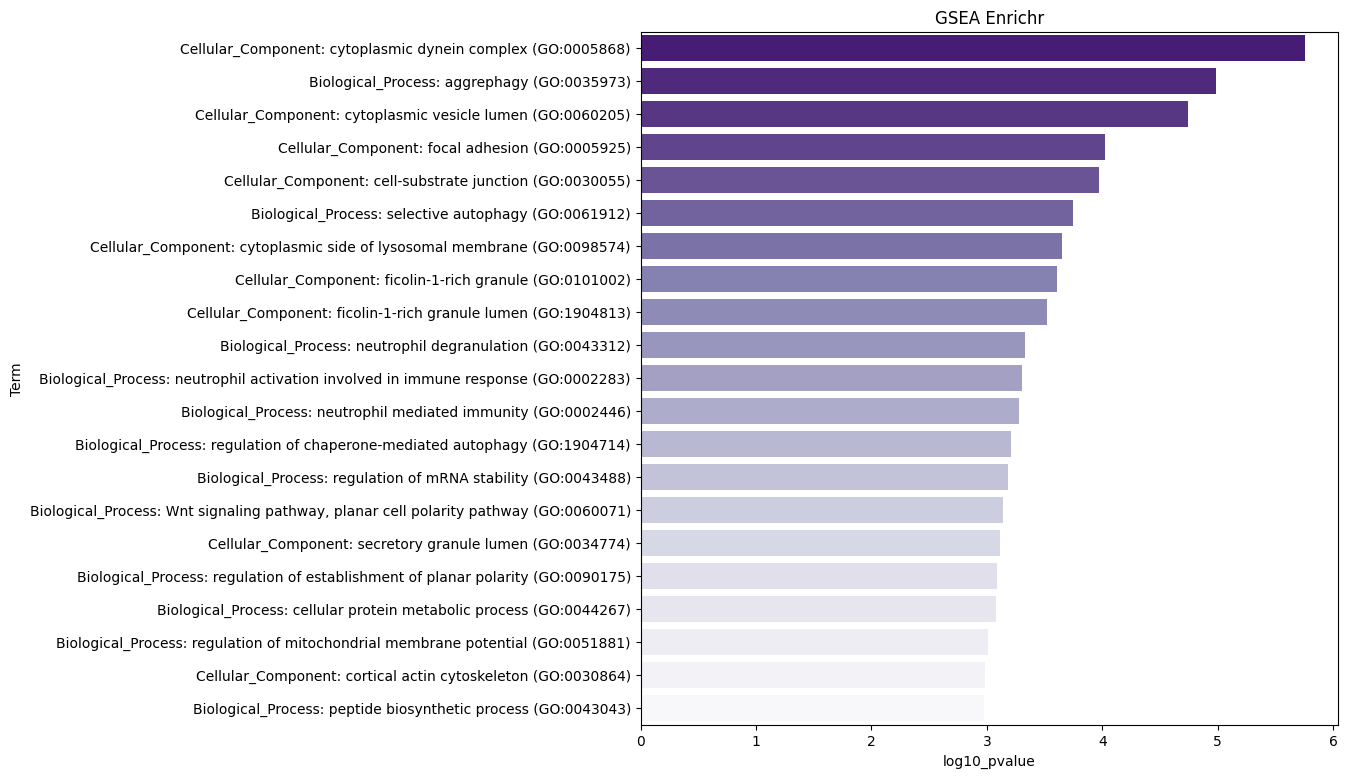

In [18]:
temp = results_df.loc[results_df.bh_fdr <= 0.05].sort_values('log10_pvalue', 
                                                             ascending=False)
temp['Gene_set'] = temp.Gene_set.str.replace('GO_','')
temp['Term'] = temp.Gene_set.str.replace('_2021',': ') + temp.Term
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': 50}):
    plt.style.use('seaborn-bright')    
    barplot(data=temp, x='log10_pvalue', y='Term', palette='Purples_r')    
    plt.title('GSEA Enrichr')
    plt.show()

### visualize the reformated data as a heatmap

13


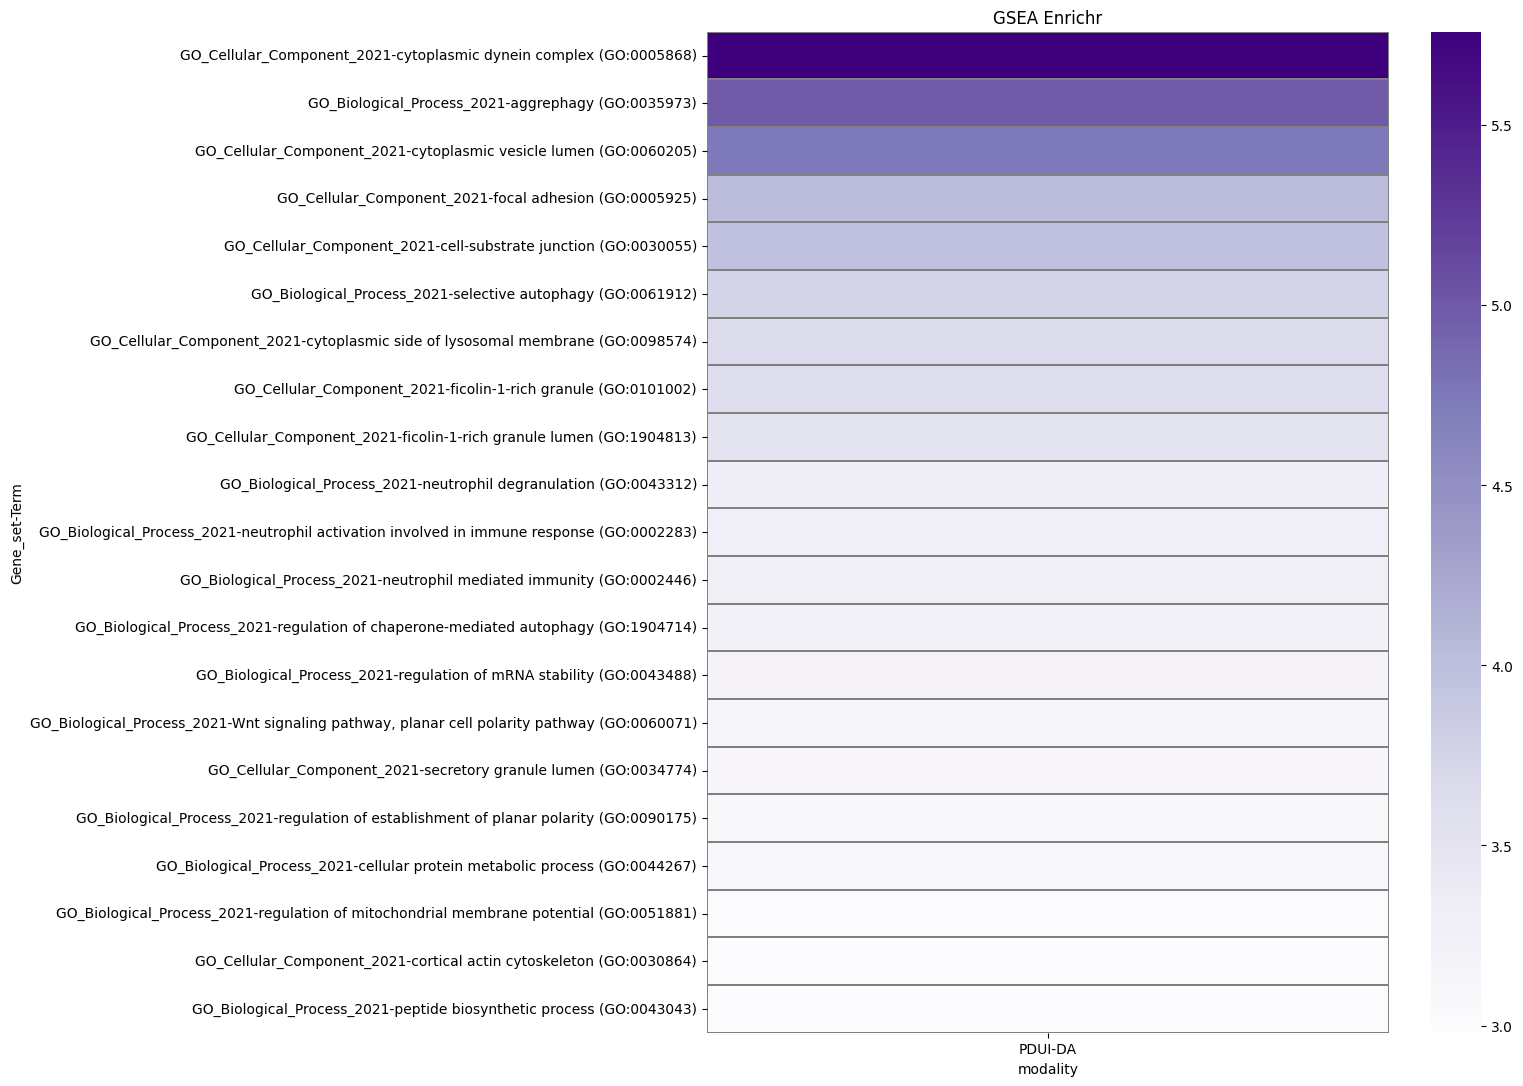

In [19]:

if wcoloc_df.shape[0] > 9:
    height = 9+ceil(wcoloc_df.shape[0]/6)
else:
    height = 9
print(height)        
with rc_context({'figure.figsize': (11, height), 'figure.dpi': 50}):
    plt.style.use('seaborn-bright')    
    heatmap(wcoloc_df, linecolor='grey', linewidths=0.05, cmap='Purples')    
    plt.title('GSEA Enrichr')
    plt.show()

In [20]:
!date

Wed Feb  8 15:34:34 UTC 2023
